In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
with open("../data/names.txt", "r") as file:
    words = file.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(itos)
vocab_size = len(stoi)
print("vocab_size: ", vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [4]:
block_size = 3

X, Y = [], []

for w in words[:3]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [6]:
for i in range(7):
    print("Input: ", Xtr[i].tolist()," Target: ", Ytr[i].item())
    print("Input: ", "".join((itos[w]) for w in Xtr[i].tolist()), " Target: ", itos[Ytr[i].item()])


Input:  [0, 0, 0]  Target:  25
Input:  ...  Target:  y
Input:  [0, 0, 25]  Target:  21
Input:  ..y  Target:  u
Input:  [0, 25, 21]  Target:  8
Input:  .yu  Target:  h
Input:  [25, 21, 8]  Target:  5
Input:  yuh  Target:  e
Input:  [21, 8, 5]  Target:  14
Input:  uhe  Target:  n
Input:  [8, 5, 14]  Target:  7
Input:  hen  Target:  g
Input:  [5, 14, 7]  Target:  0
Input:  eng  Target:  .


In [29]:
# pytorchify 

from typing import Any


class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with packprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calc forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


# hyperparameters
vocab_size = vocab_size # 27
block_size = 3 # context length (number of recent characters to predict next character)
lr_init = 0.07

n_embd = 10 # number of dimensions to represent each character
n_hidden = 100 # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
# ]
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]



with torch.no_grad():
    # make last layer less confident
    # layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [30]:
# build the dataset
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [31]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]     
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lr_init if i < (2/3 * max_steps) else lr_init / 10
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d} /{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # if i > 10000:
    #     break

      0 / 200000: 3.2750
  10000 / 200000: 2.0871
  20000 / 200000: 2.1825
  30000 / 200000: 2.2930
  40000 / 200000: 2.4937
  50000 / 200000: 2.4774
  60000 / 200000: 1.7024
  70000 / 200000: 2.0015
  80000 / 200000: 2.1664
  90000 / 200000: 1.8521
 100000 / 200000: 2.2885
 110000 / 200000: 2.0548
 120000 / 200000: 2.0631
 130000 / 200000: 1.6502
 140000 / 200000: 1.9583
 150000 / 200000: 1.7074
 160000 / 200000: 2.3462
 170000 / 200000: 1.5687
 180000 / 200000: 2.1104
 190000 / 200000: 1.5859


layer 1 (      Tanh): mean -0.03, std 0.86, saturated: 46.34%
layer 3 (      Tanh): mean -0.02, std 0.87, saturated: 47.59%
layer 5 (      Tanh): mean -0.01, std 0.89, saturated: 49.75%
layer 7 (      Tanh): mean -0.00, std 0.90, saturated: 55.06%
layer 9 (      Tanh): mean -0.03, std 0.86, saturated: 38.53%


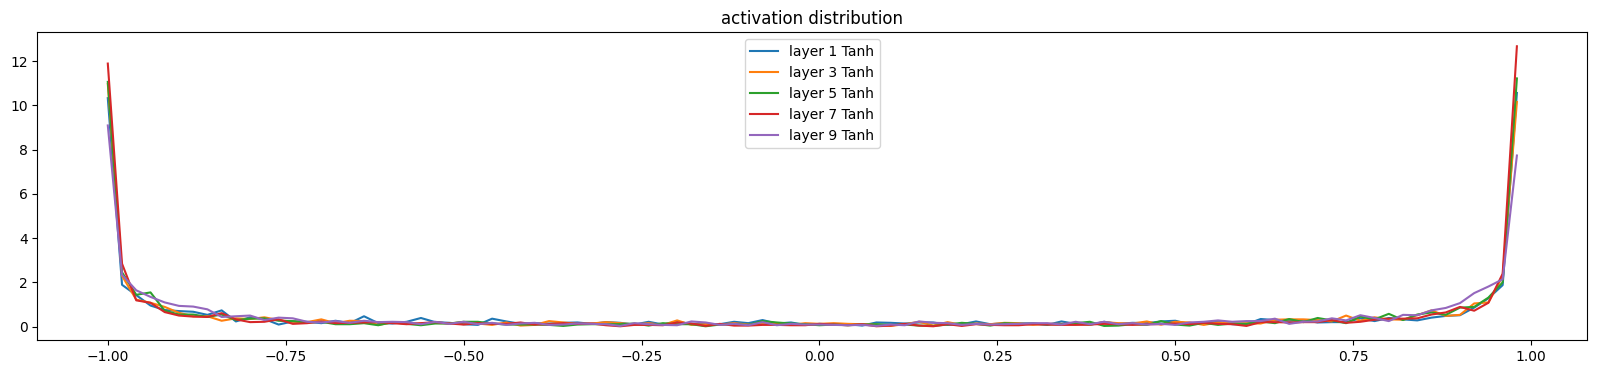

In [32]:
# vis histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.000001, std 5.235908e-03
layer 3 (      Tanh): mean +0.000064, std 4.747477e-03
layer 5 (      Tanh): mean -0.000059, std 4.598973e-03
layer 7 (      Tanh): mean -0.000090, std 4.662314e-03
layer 9 (      Tanh): mean -0.000007, std 5.168521e-03


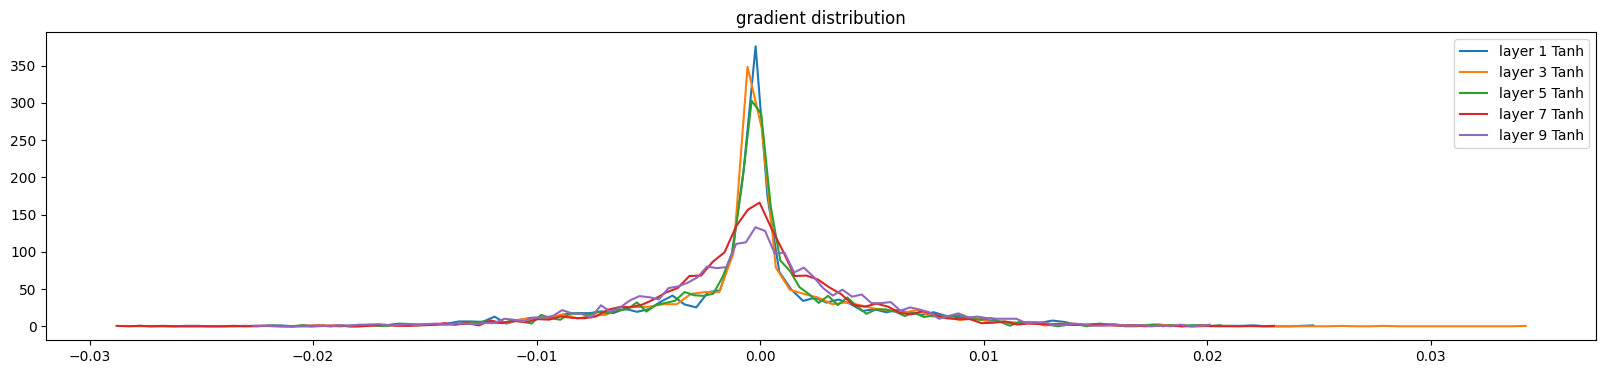

In [33]:
# vis histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000513 | std 2.488407e-02 | grad:data ratio 2.129653e-02
weight  (30, 100) | mean -0.000028 | std 1.512137e-02 | grad:data ratio 3.377876e-02
weight (100, 100) | mean -0.000038 | std 8.957278e-03 | grad:data ratio 3.361171e-02
weight (100, 100) | mean -0.000073 | std 8.535245e-03 | grad:data ratio 3.290540e-02
weight (100, 100) | mean -0.000090 | std 8.059748e-03 | grad:data ratio 3.157503e-02
weight (100, 100) | mean +0.000005 | std 8.644894e-03 | grad:data ratio 3.707244e-02
weight  (100, 27) | mean -0.000000 | std 2.473899e-02 | grad:data ratio 1.225801e-01


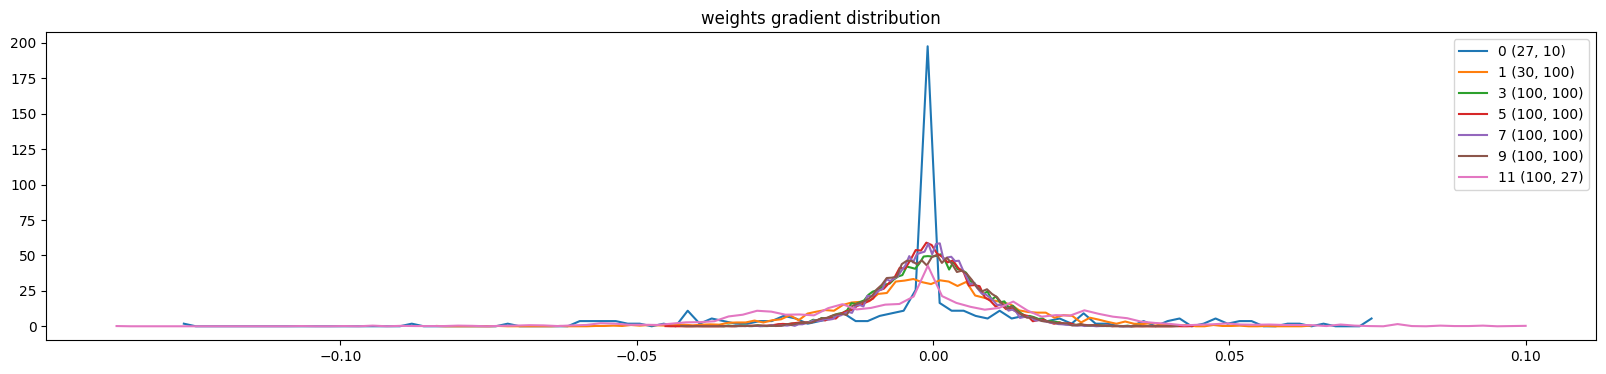

In [34]:
# vis histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

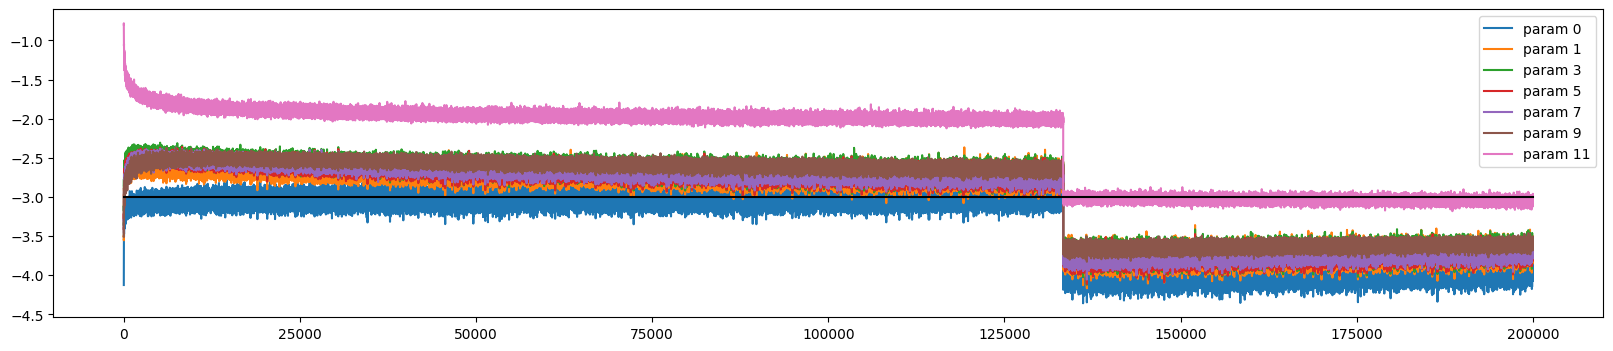

In [35]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

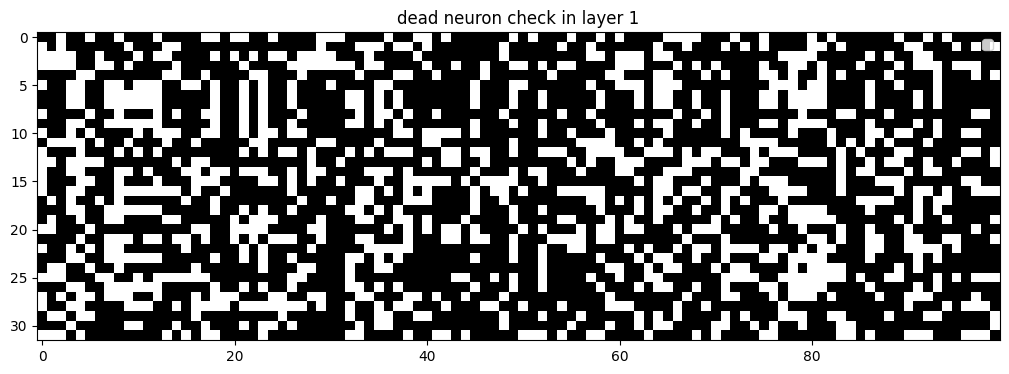

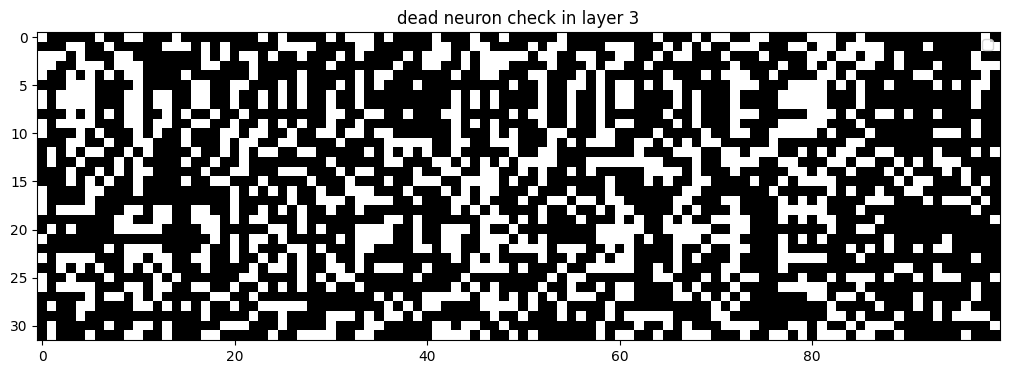

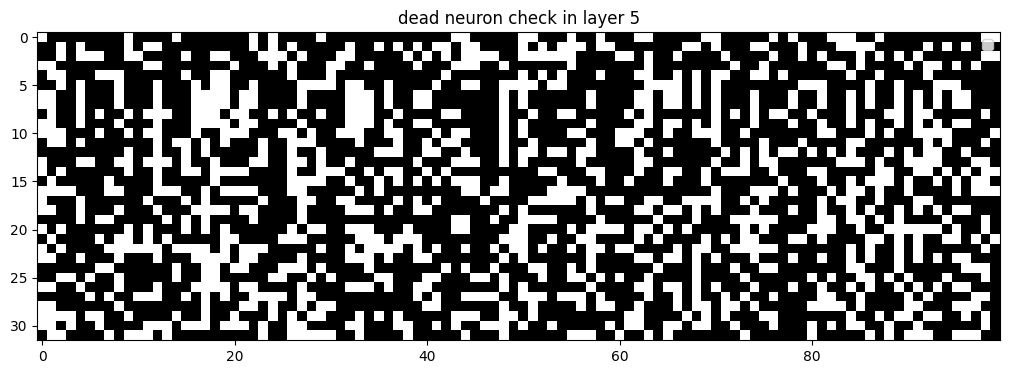

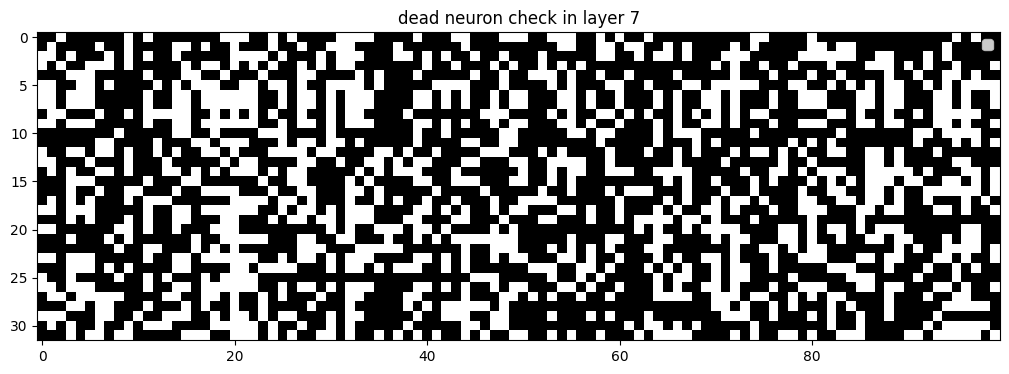

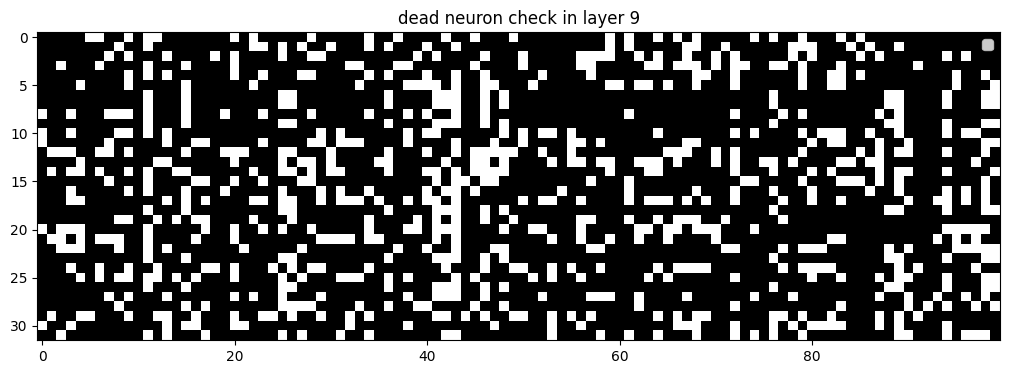

In [36]:
# vis histograms
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        plt.figure(figsize=(20,4))
        t = layer.out
        plt.imshow(t.abs() > 0.99, cmap = "grey", interpolation="nearest")
        legends.append(f'layer {i} {layer.__class__.__name__}')
        plt.legend(legends)
        plt.title(f'dead neuron check in layer {i}')
        plt.show();


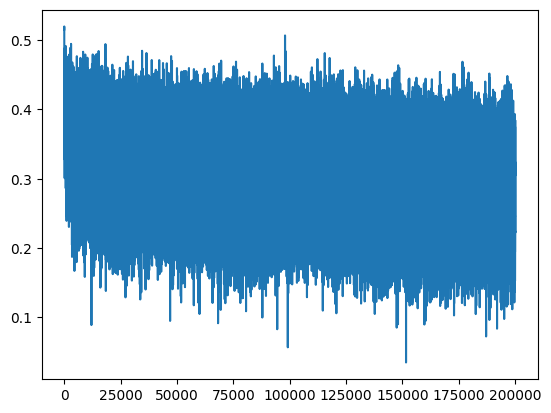

In [37]:
plt.plot(lossi);

In [38]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    # forward pass
    emb = C[x]     
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)


    # # -------------
    # emb = C[x]
    # embcat = emb.view(emb.shape[0], -1)
    # h = torch.tanh(embcat @ W1 + b1)  
    # logits = h @ W2 + b2                                           
    # loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item():.4f}")

split_loss("train")
split_loss("val")    

train: 1.9611
val: 2.0829


In [41]:
if n_embd == 2:
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid("minor");

In [39]:
# sample
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        # forward pass
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
            x = layer(x)
        probs = F.softmax(x, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

junide.
jakarie.
paulay.
adin.
kai.
ritolett.
juley.
sameia.
yamilena.
jadeyaire.
amel.
sejaicayla.
terindelmirafortum.
maryas.
jah.
jaylie.
raaya.
jocean.
jamilyn.
kmiki.
